# Set ENV Variable to Project Path

In [8]:
# Automatically reload modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Insert project root folder in environment variable

In [9]:
import os
import sys

def find_project_root(start_path=None, markers=(".git", "pyproject.toml", "requirements.txt")):
    """
    Walks up from start_path until it finds one of the marker files/folders.
    Returns the path of the project root.
    """
    if start_path is None:
        start_path = os.getcwd()

    current_path = os.path.abspath(start_path)

    while True:
        # check if any marker exists in current path
        if any(os.path.exists(os.path.join(current_path, marker)) for marker in markers):
            return current_path

        new_path = os.path.dirname(current_path)  # parent folder
        if new_path == current_path:  # reached root of filesystem
            raise FileNotFoundError(f"None of the markers {markers} found above {start_path}")
        current_path = new_path

project_root = find_project_root()
print("Project root:", project_root)

if project_root not in sys.path:
    sys.path.insert(0, project_root)


Project root: c:\ds_analytics_projects\darshil_course\apache-pyspark\darshil-pyspark


# Import Libraries

Import packages

In [10]:
import pandas as pd
import numpy as np
from pathlib import Path

Relative import

In [11]:
from utils.file_utils import get_project_path

In [12]:
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("RDD") \
    .config("spark.sql.catalogImplementation", "hive") \
    .enableHiveSupport() \
    .getOrCreate()

# **Distributed Shared Variables**

In addition to the **Resilient Distributed Dataset (RDD)** interface, Spark provides another set of **low-level APIs**: **distributed shared variables**. These are useful for efficiently sharing or collecting information across a cluster.

There are **two types of distributed shared variables** in Spark:

1. **Broadcast Variables (BV)**
2. **Accumulators (AV)**

---

## **1. Broadcast Variables**

📌 **Problem**: Normally, when you pass a variable from the Driver into tasks, Spark serializes it and sends it with every task. This is inefficient for large objects (like lookup tables, ML models, or config maps).

📌 **Solution**: **Broadcast variables** are:

- **Immutable** (cannot be changed once created).
- **Cached on all Executors**, avoiding repeated transfers.
- Perfect for distributing **large read-only objects** across workers.

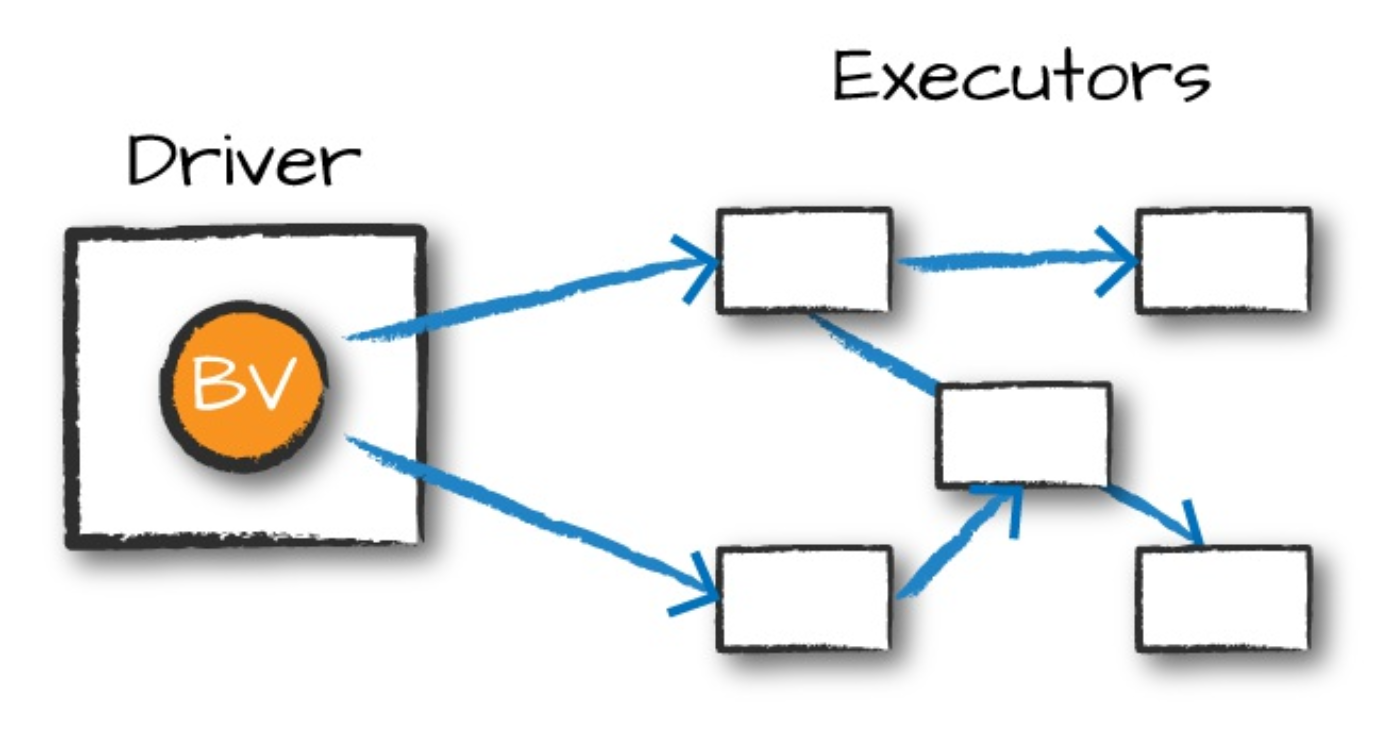

Driver broadcasts variable once → Executors cache locally → tasks reuse it.

---

### Example: Using a Broadcast Variable

In [13]:
myCollection = "My Name is Darshil and I love Spark".split(" ")
words = spark.sparkContext.parallelize(myCollection, 2)

# Large lookup table (could be MBs/GBs)
supplementalData = {"Name": 1000, "Darshil": 200,
                    "love": -300, "Spark": 100}

# Broadcast it to Executors
suppBroadcast = spark.sparkContext.broadcast(supplementalData)

# Access broadcasted value
print(suppBroadcast.value)

# Use inside transformations
words.map(lambda word: (word, suppBroadcast.value.get(word, 0))) \
     .sortBy(lambda wordPair: wordPair[1]) \
     .collect()

{'Name': 1000, 'Darshil': 200, 'love': -300, 'Spark': 100}


[('love', -300),
 ('My', 0),
 ('is', 0),
 ('and', 0),
 ('I', 0),
 ('Spark', 100),
 ('Darshil', 200),
 ('Name', 1000)]

✅ **Efficient** – lookup table sent once.

❌ **Without BV** – lookup table would be sent with every task (high network overhead).

---

## **2. Accumulators**

📌 **Problem**: How do we collect values or counters from many Executors back to the Driver in a **safe** and **fault-tolerant** way?

📌 **Solution**: **Accumulators** are:

- **Write-only shared variables**.
- Executors update them; Driver collects the results.
- Used for **counters, debugging, custom aggregations**.
- Guarantee: Updates inside **actions** are applied exactly once.
    
    (⚠️ Inside **transformations**, they may be applied more than once if a task is retried.)

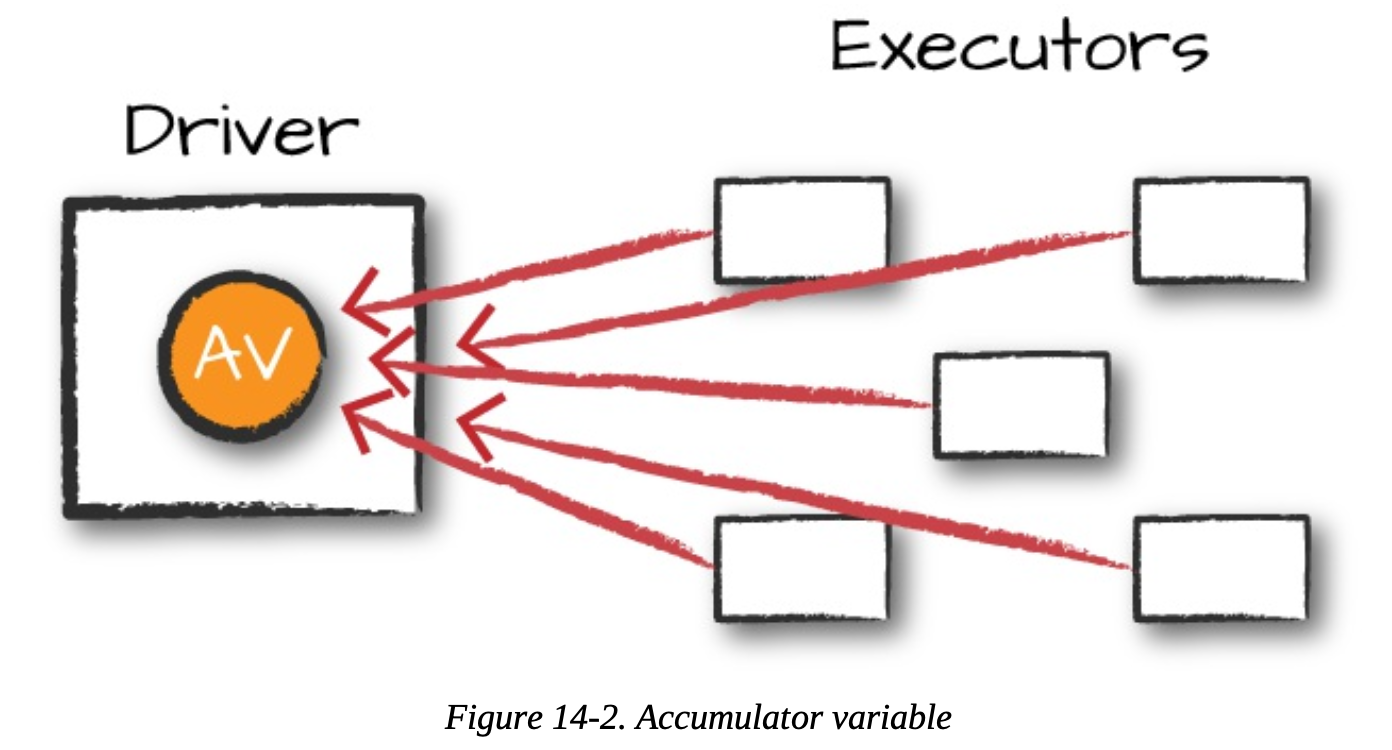

Executors push updates → Driver aggregates them into one global value.

---

### Example: Using an Accumulator

In [14]:
# Load dataset
flights = spark.read.parquet(get_project_path('data', 'darshil-data', 'flight-data', 'parquet', '2010-summary.parquet'))

# Create accumulator
accChina = spark.sparkContext.accumulator(0)

# Define update logic
def accChinaFunc(flight_row):
    destination = flight_row["DEST_COUNTRY_NAME"]
    origin = flight_row["ORIGIN_COUNTRY_NAME"]
    if destination == "China":
        accChina.add(flight_row["count"])
    if origin == "China":
        accChina.add(flight_row["count"])

# Apply updates (action required: foreach)
flights.foreach(lambda flight_row: accChinaFunc(flight_row))

# Final value collected at Driver
print(accChina.value)  # e.g., 953

953


✅ **Good for**: Counters, error tracking, debugging metrics.

❌ **Not for business logic**: They don't participate in transformations.

---

## **Comparison: Broadcast vs Accumulator**

| Feature | **Broadcast Variables (BV)** | **Accumulators (AV)** |
| --- | --- | --- |
| Purpose | Share large, read-only data with Executors | Collect aggregated values from Executors |
| Direction | Driver → Executors (one-to-many) | Executors → Driver (many-to-one) |
| Mutability | Immutable | Mutable (but write-only) |
| Use Cases | Lookup tables, ML models, config | Counters, debugging, metrics |
| Efficiency | Avoids redundant task serialization | Fault-tolerant aggregation |

---

⚡ **Key Insight**:

- Use **Broadcast** when you want to *send data out* to workers.
- Use **Accumulator** when you want to *collect values back* from workers.